# 🤖 SP1: 3D Open-Vocabulary Object Detection Pipeline

**Testing Notebook for GitHub Repository**

This notebook clones and tests the SP1 pipeline from:
- **Repository**: https://github.com/Zulqarnain-cc34/3d_detection

---

## ⚡ Quick Start
1. Run **Section 1** to setup (clone repo + install)
2. Run **Section 2** to test the pipeline
3. If you push changes to GitHub, run **Section 1.2** to pull latest

---

# 1. Setup Environment

### 1.0 Check GPU (Optional but Recommended)
Go to **Runtime → Change runtime type → GPU (T4)**

In [1]:
# Check if GPU is available
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("⚠️ No GPU detected. Pipeline will run on CPU (slower).")

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4
Memory: 15.8 GB


### 1.1 Clone Repository (Run Once)

In [2]:
import os

# Repository URL
REPO_URL = "https://github.com/Zulqarnain-cc34/3d_detection.git"
REPO_NAME = "3d_detection"

# Clone if not exists
if not os.path.exists(REPO_NAME):
    print("📥 Cloning repository...")
    !git clone {REPO_URL}
    print("✅ Repository cloned!")
else:
    print(f"📁 Repository '{REPO_NAME}' already exists.")
    print("   Run the next cell (1.2) to pull latest changes.")

# Change to repo directory
%cd {REPO_NAME}

# Show current commit
print("\n📌 Current commit:")
!git log -1 --oneline

📥 Cloning repository...
Cloning into '3d_detection'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 21 (delta 3), reused 21 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (21/21), 32.07 KiB | 513.00 KiB/s, done.
Resolving deltas: 100% (3/3), done.
✅ Repository cloned!
/content/3d_detection

📌 Current commit:
e425d56 (HEAD -> main, origin/main, origin/HEAD) fixed


### 1.2 Pull Latest Changes (Run After Each GitHub Push) 🔄

In [3]:
# ===================================================
# 🔄 RUN THIS CELL AFTER YOU PUSH CHANGES TO GITHUB
# ===================================================

import os
REPO_NAME = "3d_detection"

# Make sure we're in the repo directory
if os.path.basename(os.getcwd()) != REPO_NAME:
    %cd /content/{REPO_NAME}

print("📥 Pulling latest changes from GitHub...")
!git fetch origin
!git reset --hard origin/main  # Use 'master' if your branch is named master

print("\n✅ Updated to latest commit:")
!git log -1 --oneline

print("\n📁 Repository contents:")
!ls -la

📥 Pulling latest changes from GitHub...
HEAD is now at e425d56 fixed

✅ Updated to latest commit:
e425d56 (HEAD -> main, origin/main, origin/HEAD) fixed

📁 Repository contents:
total 72
drwxr-xr-x 5 root root  4096 Dec 18 11:38 .
drwxr-xr-x 1 root root  4096 Dec 18 11:38 ..
drwxr-xr-x 2 root root  4096 Dec 18 11:38 configs
drwxr-xr-x 8 root root  4096 Dec 18 11:38 .git
-rw-r--r-- 1 root root  9220 Dec 18 11:38 proposal.md
-rw-r--r-- 1 root root  8440 Dec 18 11:38 README.md
-rw-r--r-- 1 root root   785 Dec 18 11:38 requirements.txt
-rw-r--r-- 1 root root 10186 Dec 18 11:38 run_test.py
drwxr-xr-x 2 root root  4096 Dec 18 11:38 src
-rw-r--r-- 1 root root 11375 Dec 18 11:38 test_notebook.ipynb


### 1.3 Install Dependencies

In [4]:
# Install required packages
print("📦 Installing dependencies...")

!pip install -r /content/3d_detection/requirements.txt

# Explicitly upgrade ultralytics to ensure latest device handling fixes
print("⬆️ Upgrading ultralytics...")
!pip install ultralytics --upgrade

print("✅ Dependencies installed and ultralytics upgraded!")

📦 Installing dependencies...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 kB 20.9 MB/s eta 0:00:00
⬆️ Upgrading ultralytics...
✅ Dependencies installed and ultralytics upgraded!


### 1.4 Import Pipeline

In [5]:
import sys
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import requests
from io import BytesIO

# Add src to Python path
REPO_NAME = "3d_detection"
if os.path.basename(os.getcwd()) != REPO_NAME:
    %cd /content/{REPO_NAME}

# Reload modules if already imported (for when you pull updates)
if 'src' in sys.modules:
    import importlib
    import src
    importlib.reload(src)
    from src import pipeline, detector, depth_estimator, projector, visualizer
    importlib.reload(pipeline)
    importlib.reload(detector)
    importlib.reload(depth_estimator)
    importlib.reload(projector)
    importlib.reload(visualizer)
    print("🔄 Modules reloaded!")

# Import pipeline components
from src import SP1Pipeline, PipelineVisualizer

print("✅ Imports successful!")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ Imports successful!


---
# 2. Test Pipeline

### 2.1 Initialize Pipeline

In [6]:
import torch

# Auto-detect device
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"🖥️ Using device: {DEVICE}")

# Initialize pipeline
print("\n" + "="*60)
print("Initializing SP1 3D Detection Pipeline")
print("="*60)
pipeline = SP1Pipeline(
    detector_model='yolov8s-world',
    device='cuda:0',
    confidence_threshold=0.25,
    min_depth=0.5,
    max_depth=10.0
)

# CUDA-FIX: Ensure all sub-models are on GPU (CORRECTED)
pipeline.detector.model.to('cuda:0')
torch.cuda.empty_cache()
print(f"✅ Detector forced to CUDA:0 | GPU Memory: {torch.cuda.memory_allocated()/1e9:.1f}GB")
print("Pipeline initialized successfully!")

🖥️ Using device: cuda:0

Initializing SP1 3D Detection Pipeline
Initializing SP1 3D Detection Pipeline
[Stage A] Loading yolov8s-world...
[Stage A] Model loaded successfully on cuda:0
[Stage B] Loading depth-anything/Depth-Anything-V2-Metric-Outdoor-Small-hf...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/99.2M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


[Stage B] Model loaded successfully
Pipeline initialized successfully!
✅ Detector forced to CUDA:0 | GPU Memory: 0.2GB
Pipeline initialized successfully!


### 2.2 Load Test Image

📥 Downloading test image...
✅ Image loaded: (706, 800, 3)


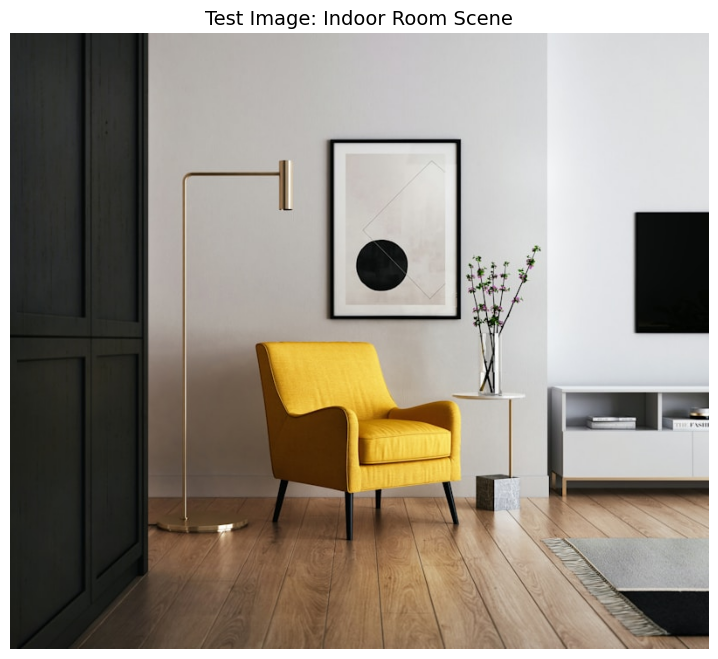

In [7]:
# Download sample indoor scene image
IMAGE_URL = "https://images.unsplash.com/photo-1586023492125-27b2c045efd7?w=800"

print("📥 Downloading test image...")
response = requests.get(IMAGE_URL)
image = Image.open(BytesIO(response.content)).convert('RGB')
image_np = np.array(image)

print(f"✅ Image loaded: {image_np.shape}")

# Display image
plt.figure(figsize=(12, 8))
plt.imshow(image_np)
plt.title("Test Image: Indoor Room Scene", fontsize=14)
plt.axis('off')
plt.show()

### 2.3 Run 3D Object Detection

In [8]:
# Define objects to detect (open-vocabulary!)
QUERY_CLASSES = [
    "chair", "sofa", "table", "lamp",
    "tv", "door", "window", "plant", "pillow"
]

print(f"🔍 Searching for: {QUERY_CLASSES}")
print("\n⏳ Running pipeline...")

# Run detection
result = pipeline.detect(image_np, QUERY_CLASSES)

# Print summary
print("\n" + result.summary())

🔍 Searching for: ['chair', 'sofa', 'table', 'lamp', 'tv', 'door', 'window', 'plant', 'pillow']

⏳ Running pipeline...
requirements: Ultralytics requirement ['git+https://github.com/ultralytics/CLIP.git'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 34 packages in 557ms
Prepared 2 packages in 2.09s
Installed 2 packages in 1ms
 + clip==1.0 (from git+https://github.com/ultralytics/CLIP.git@643beff3883b5720d94b6b9c9eca12fa9fb72fb1)
 + ftfy==6.3.1

requirements: AutoUpdate success ✅ 3.1s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect



100%|███████████████████████████████████████| 338M/338M [00:06<00:00, 57.5MiB/s]


[Stage A] Classes set: ['chair', 'sofa', 'table', 'lamp', 'tv', 'door', 'window', 'plant', 'pillow']

=== SP1 3D Detection Results ===
Image: N/A
Shape: (706, 800, 3)
Query: ['chair', 'sofa', 'table', 'lamp', 'tv', 'door', 'window', 'plant', 'pillow']

Detections (4 objects):
  [1] chair: depth=4.00m, conf=0.94
  [2] tv: depth=5.60m, conf=0.57
  [3] table: depth=5.38m, conf=0.45
  [4] lamp: depth=5.01m, conf=0.38

Timing:
  Detection: 1228.2ms
  Depth: 211.2ms
  Projection: 4.7ms
  Total: 1444.0ms
  FPS: 0.7


### 2.4 Visualize Results

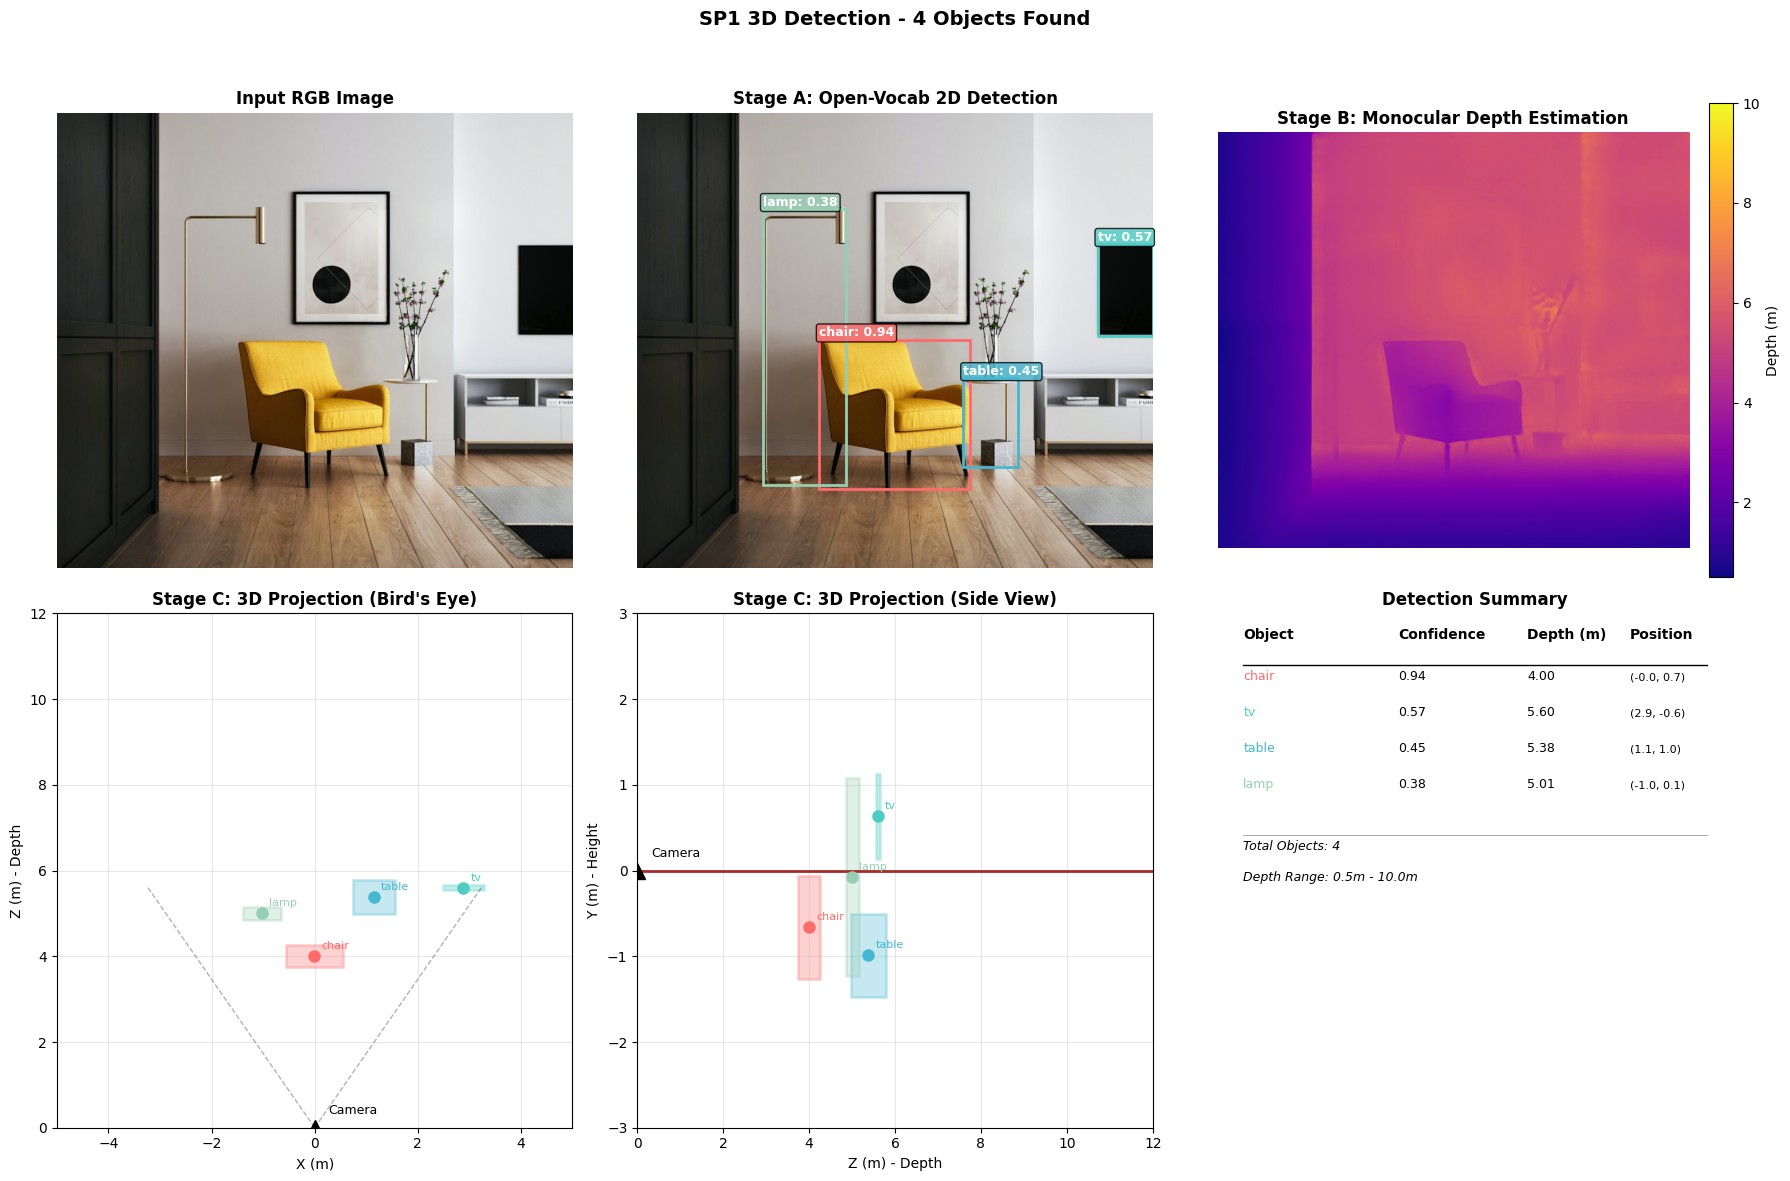

In [9]:
# Create comprehensive visualization
viz = PipelineVisualizer()

fig = viz.visualize_pipeline_result(
    image=image_np,
    detections_2d=result.detections_2d,
    depth_result=result.depth_result,
    detections_3d=result.detections_3d,
    title=f"SP1 3D Detection - {len(result.detections_3d)} Objects Found"
)

plt.show()

### 2.5 Detailed 3D Results

In [10]:
print("=" * 60)
print("DETAILED 3D DETECTION RESULTS")
print("=" * 60)

for i, det in enumerate(result.detections_3d):
    print(f"\n[{i+1}] {det.class_name.upper()}")
    print(f"    Confidence: {det.confidence:.2%}")
    print(f"    3D Position: X={det.center[0]:.2f}m, Y={det.center[1]:.2f}m, Z={det.center[2]:.2f}m")
    print(f"    Dimensions:  W={det.dimensions[0]:.2f}m, H={det.dimensions[1]:.2f}m, D={det.dimensions[2]:.2f}m")
    print(f"    Distance from camera: {det.center[2]:.2f} meters")

if not result.detections_3d:
    print("\n❌ No objects detected. Try lowering confidence threshold.")

DETAILED 3D DETECTION RESULTS

[1] CHAIR
    Confidence: 93.56%
    3D Position: X=-0.01m, Y=0.66m, Z=4.00m
    Dimensions:  W=1.10m, H=1.21m, D=0.50m
    Distance from camera: 4.00 meters

[2] TV
    Confidence: 56.87%
    3D Position: X=2.89m, Y=-0.63m, Z=5.60m
    Dimensions:  W=0.79m, H=0.99m, D=0.10m
    Distance from camera: 5.60 meters

[3] TABLE
    Confidence: 45.20%
    3D Position: X=1.15m, Y=0.99m, Z=5.38m
    Dimensions:  W=0.82m, H=0.97m, D=0.80m
    Distance from camera: 5.38 meters

[4] LAMP
    Confidence: 38.49%
    3D Position: X=-1.02m, Y=0.07m, Z=5.01m
    Dimensions:  W=0.75m, H=2.31m, D=0.30m
    Distance from camera: 5.01 meters


### 2.6 Navigation Waypoint Test

In [11]:
import torch

# Test waypoint generation for robot navigation
TARGET_OBJECT = "sofa"  # Change this to test different objects

print(f"🎯 Generating navigation waypoint to: '{TARGET_OBJECT}'")

# Explicitly ensure the detector model and its internal CLIP model are on the correct device
if hasattr(pipeline, 'detector') and hasattr(pipeline.detector, 'model'):
    # Check and move the main YOLO model if necessary

    if pipeline.detector.model.device != torch.device(DEVICE):
        print(f"🔄 Moving main detector model from {pipeline.detector.model.device} to {DEVICE}...")
        pipeline.detector.model.to(DEVICE)

    # Check and move the internal CLIP text encoder (used by YOLO-World) if necessary
    # The exact attribute name might vary slightly between ultralytics versions
    if hasattr(pipeline.detector.model.model, 'text_encoder') and pipeline.detector.model.model.text_encoder is not None:
        if pipeline.detector.model.model.text_encoder.device != torch.device(DEVICE):
            print(f"🔄 Moving YOLO-World text encoder from {pipeline.detector.model.model.text_encoder.device} to {DEVICE}...")
            pipeline.detector.model.model.text_encoder.to(DEVICE)
    elif hasattr(pipeline.detector.model.model, 'clip_model') and pipeline.detector.model.model.clip_model is not None: # Fallback for older versions
        if pipeline.detector.model.model.clip_model.device != torch.device(DEVICE):
            print(f"🔄 Moving YOLO-World clip_model from {pipeline.detector.model.model.clip_model.device} to {DEVICE}...")
            pipeline.detector.model.model.clip_model.to(DEVICE)
    else:
        print("⚠️ Could not find internal text encoder/CLIP model to explicitly move to device. Proceeding anyway.")

waypoint = pipeline.get_waypoint(
    image_np,
    target_object=TARGET_OBJECT,
    offset_distance=0.5  # Stop 0.5m from object
)

if waypoint:
    print(f"\n✅ Waypoint generated!")
    print(f"   Object position:  {[f'{x:.2f}' for x in waypoint['object_position']]} meters")
    print(f"   Waypoint (stop):  {[f'{x:.2f}' for x in waypoint['waypoint_position']]} meters")
    print(f"   Distance to obj:  {waypoint['distance_to_object']:.2f} meters")
    print(f"   Confidence:       {waypoint['confidence']:.2%}")
else:
    print(f"\n❌ '{TARGET_OBJECT}' not found in scene")

🎯 Generating navigation waypoint to: 'sofa'
[Stage A] Classes set: ['sofa']

✅ Waypoint generated!
   Object position:  ['-0.01', '0.66', '4.00'] meters
   Waypoint (stop):  ['-0.01', '0.58', '3.51'] meters
   Distance to obj:  4.06 meters
   Confidence:       93.34%
